<a href="https://colab.research.google.com/github/Ordo-Umbra/Void-Defect-Model/blob/main/Defect_Sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import numpy as np

def gaussian_kernel(d, R):
    return np.exp(-2 * (R**2) * (d**2))

def compute_field(x, positions, energies, ranges):
    field = 0.0
    for i in range(len(positions)):
        d = np.linalg.norm(x - positions[i])
        field += energies[i] * gaussian_kernel(d, ranges[i])
    return field

def compute_force(i, positions, energies, ranges):
    ri = positions[i]
    force = np.zeros(3)
    for j in range(len(positions)):
        if i == j:
            continue
        rj = positions[j]
        d_vec = ri - rj
        d = np.linalg.norm(d_vec)
        if d == 0:
            continue
        grad = -4 * energies[j] * (ranges[j]**2) * d_vec \
               * np.exp(-2 * (ranges[j]**2) * (d**2))
        force += grad
    return force

In [21]:
import numpy as np

def initialize_particles(n):
    positions = np.random.uniform(-2, 2, (n, 3))
    velocities = np.random.uniform(-0.2, 0.2, (n, 3))
    energies = np.random.uniform(1.0, 5.0, n)
    ranges  = np.random.uniform(0.5, 1.5, n)
    return positions, velocities, energies, ranges

def tick(positions, velocities, energies, ranges, dt=0.01, chaos_amp=0.05):
    new_pos = positions.copy()
    new_vel = velocities.copy()
    for i in range(len(positions)):
        f    = compute_force(i, positions, energies, ranges)
        chaos = np.random.uniform(-1, 1, 3) * chaos_amp
        new_vel[i] += dt * f + chaos
        new_pos[i] += dt * new_vel[i]
    return new_pos, new_vel

def run_simulation(n_particles=20, n_ticks=200, dt=0.001, chaos_amp=0.05):
    pos, vel, e, r = initialize_particles(n_particles)
    traj = [pos.copy()]
    for _ in range(n_ticks):
        pos, vel = tick(pos, vel, e, r, dt, chaos_amp)
        traj.append(pos.copy())
    return traj, e, r

In [23]:
import numpy as np
from sklearn.cluster import DBSCAN

def get_cluster_colors(positions, eps=0.3, min_samples=2):
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(positions)
    labels = clustering.labels_
    unique = np.unique(labels)
    mapping = {lbl:i for i,lbl in enumerate(unique)}
    colors = np.array([mapping[lbl] for lbl in labels])
    return colors.astype(float)/max(1,colors.max()), labels

def track_cluster_counts(trajectory):
    counts = []
    for frame in trajectory:
        _, labels = get_cluster_colors(frame[:, :2])
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        counts.append(n_clusters)
    return counts

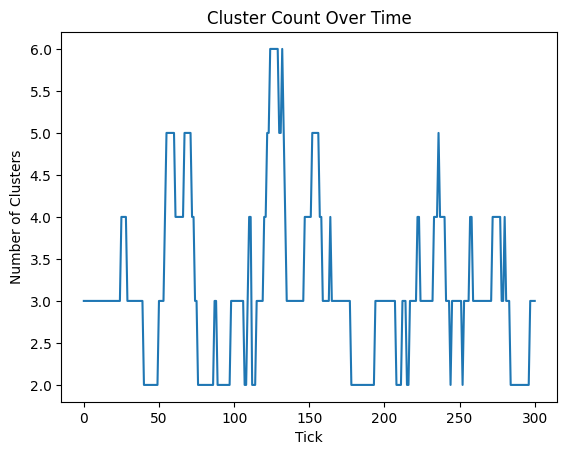

/tmp/ipython-input-2643623767.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scat = ax.scatter([], [], s=50, cmap='viridis')


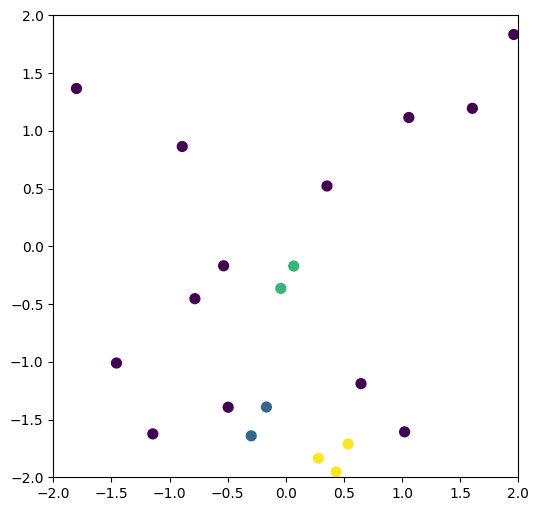

In [27]:
# Run the sim
trajectory, energies, ranges = run_simulation(20, 300, dt=0.01, chaos_amp=0.09)

# Plot cluster count
cluster_counts = track_cluster_counts(trajectory)
import matplotlib.pyplot as plt
plt.plot(cluster_counts); plt.title("Cluster Count Over Time"); plt.xlabel("Tick"); plt.ylabel("Number of Clusters"); plt.show()

# Animate
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

traj = np.array(trajectory)
fig, ax = plt.subplots(figsize=(6,6))
scat = ax.scatter([], [], s=50, cmap='viridis')
ax.set_xlim(-2,2); ax.set_ylim(-2,2)

def update(frame):
    pos = traj[frame]
    colors, _ = get_cluster_colors(pos[:, :2])
    rgba = plt.get_cmap('viridis')(colors.flatten())
    scat.set_offsets(pos[:, :2])
    scat.set_facecolor(rgba)
    return scat,

ani = FuncAnimation(fig, update, frames=range(0, len(traj), ), interval=100)
HTML(ani.to_html5_video())

In [28]:
def compute_loyalty_matrix(trajectory, eps=0.3, min_samples=2):
    n = trajectory[0].shape[0]
    loyalty = np.zeros((n, n))

    for frame in trajectory:
        _, labels = get_cluster_colors(frame[:, :2], eps=eps, min_samples=min_samples)
        for i in range(n):
            for j in range(i+1, n):
                if labels[i] != -1 and labels[i] == labels[j]:
                    loyalty[i, j] += 1
                    loyalty[j, i] += 1
    return loyalty

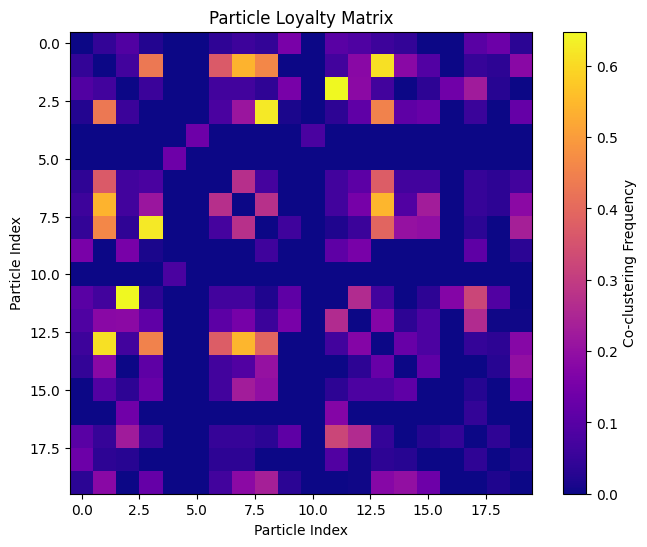

In [29]:
loyalty_matrix = compute_loyalty_matrix(trajectory)
normalized = loyalty_matrix / len(trajectory)

plt.figure(figsize=(8,6))
plt.imshow(normalized, cmap='plasma', interpolation='nearest')
plt.colorbar(label='Co-clustering Frequency')
plt.title("Particle Loyalty Matrix")
plt.xlabel("Particle Index")
plt.ylabel("Particle Index")
plt.show()

In [30]:
threshold = 0.5
n = normalized.shape[0]

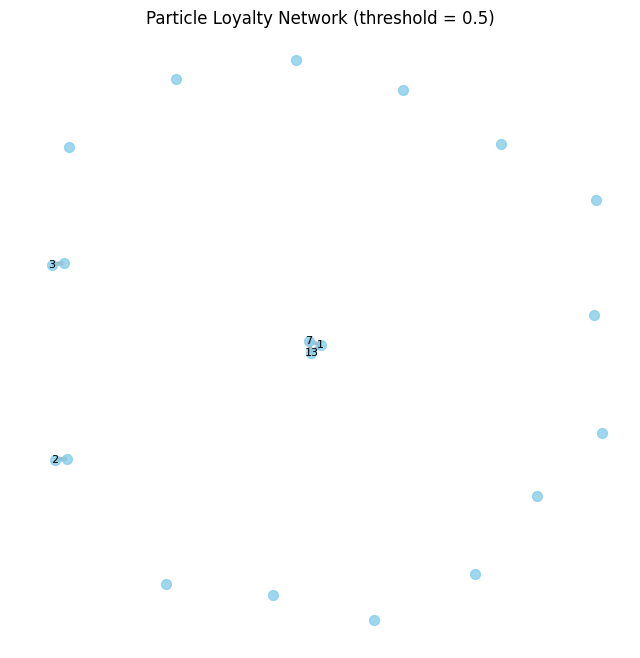

In [32]:
import networkx as nx
import matplotlib.pyplot as plt

# 1. Create graph
G = nx.Graph()
G.add_nodes_from(range(n))

# 2. Add edges for loyalty > threshold
for i in range(n):
    for j in range(i+1, n):
        if normalized[i, j] >= threshold:
            G.add_edge(i, j, weight=normalized[i, j])

# 3. Choose a layout
pos = nx.spring_layout(G, k=0.1, iterations=50, seed=42)

# 4. Draw nodes
plt.figure(figsize=(8,8))
nx.draw_networkx_nodes(
    G, pos,
    node_size=50,
    node_color='skyblue',
    alpha=0.8
)

# 5. Draw edges with width ∝ weight
edges = G.edges(data=True)
weights = [d['weight'] for (_,_,d) in edges]
nx.draw_networkx_edges(
    G, pos,
    edgelist=edges,
    width=[w * 5 for w in weights],  # scale up for visibility
    alpha=0.6,
    edge_color='gray'
)

# 6. Optional: annotate a few high-degree nodes
high_deg = sorted(G.degree, key=lambda x: x[1], reverse=True)[:5]
labels = {node: str(node) for node,_ in high_deg}
nx.draw_networkx_labels(G, pos, labels, font_size=8)

plt.title(f"Particle Loyalty Network (threshold = {threshold})")
plt.axis('off')
plt.show()

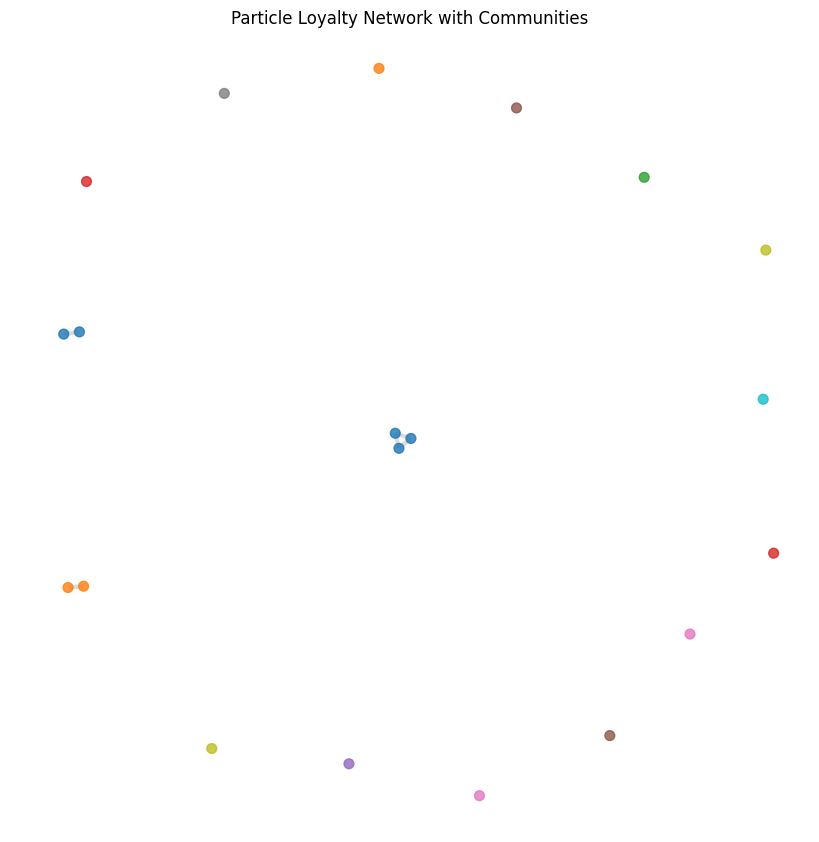

In [33]:
from networkx.algorithms import community

# Run greedy modularity communities
communities = community.greedy_modularity_communities(G, weight='weight')

# Assign a color to each community
node_colors = {}
palette = plt.cm.tab10
for i, comm in enumerate(communities):
    for node in comm:
        node_colors[node] = palette(i / len(communities))

# Draw with community colors
plt.figure(figsize=(8,8))
nx.draw(
    G, pos,
    node_color=[node_colors[n] for n in G.nodes()],
    node_size=50,
    edge_color='lightgray',
    width=[d['weight']*5 for _,_,d in G.edges(data=True)],
    alpha=0.8
)
plt.title("Particle Loyalty Network with Communities")
plt.show()

In [35]:
def sample_field_2d(positions, energies, ranges, grid_size=50, bounds=(-2, 2)):
    xs = np.linspace(bounds[0], bounds[1], grid_size)
    ys = np.linspace(bounds[0], bounds[1], grid_size)
    field_grid = np.zeros((grid_size, grid_size))
    for i, xi in enumerate(xs):
        for j, yj in enumerate(ys):
            pt = np.array([xi, yj, 0.0])  # z=0 slice
            field_grid[j, i] = compute_field(pt, positions, energies, ranges)
    return xs, ys, field_grid

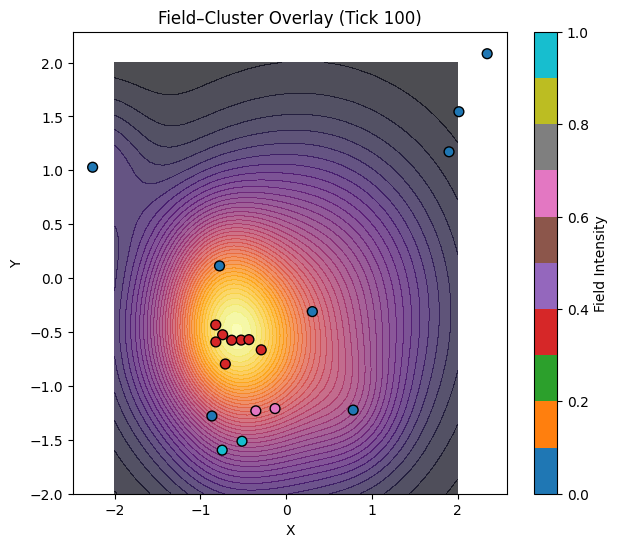

In [36]:
frame_idx = 100  # example tick
pos = trajectory[frame_idx]
colors, labels = get_cluster_colors(pos[:, :2])

xs, ys, field_grid = sample_field_2d(pos, energies, ranges)

plt.figure(figsize=(7,6))
plt.contourf(xs, ys, field_grid, levels=50, cmap='inferno', alpha=0.7)
plt.scatter(pos[:,0], pos[:,1], c=colors, cmap='tab10', edgecolor='k', s=50)
plt.colorbar(label="Field Intensity")
plt.title(f"Field–Cluster Overlay (Tick {frame_idx})")
plt.xlabel("X"); plt.ylabel("Y")
plt.show()

In [ ]:
from scipy.stats import pearsonr

field_at_particles = np.array([
    compute_field(np.array([x, y, 0.0]), pos, energies, ranges)
    for x, y in pos[:, :2]
])

# Example: correlation between field and cluster ID
corr, pval = pearsonr(field_at_particles, colors)
print(f"Pearson correlation: {corr:.3f} (p={pval:.3g})")

Pearson correlation: -0.197 (p=0.00506)


/tmp/ipython-input-1043780465.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scat = ax.scatter([], [], s=50, cmap='tab10', edgecolor='k')


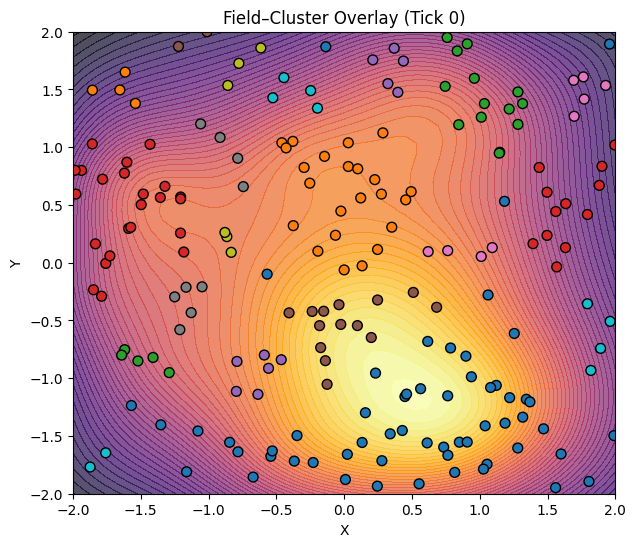

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Precompute trajectory array for speed
traj = np.array(trajectory)

# Set up figure
fig, ax = plt.subplots(figsize=(7,6))
xs, ys, field_grid = sample_field_2d(traj[0], energies, ranges)
contour = ax.contourf(xs, ys, field_grid, levels=50, cmap='inferno', alpha=0.7)
scat = ax.scatter([], [], s=50, cmap='tab10', edgecolor='k')

ax.set_xlim(xs.min(), xs.max())
ax.set_ylim(ys.min(), ys.max())
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Field–Cluster Overlay")

# Update function
def update(frame):
    pos = traj[frame]
    colors, _ = get_cluster_colors(pos[:, :2])

    # Recompute field for this frame
    xs, ys, field_grid = sample_field_2d(pos, energies, ranges)
    ax.clear()
    ax.contourf(xs, ys, field_grid, levels=50, cmap='inferno', alpha=0.7)
    ax.scatter(pos[:,0], pos[:,1], c=colors, cmap='tab10', edgecolor='k', s=50)

    ax.set_xlim(xs.min(), xs.max())
    ax.set_ylim(ys.min(), ys.max())
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title(f"Field–Cluster Overlay (Tick {frame})")
    return []

# Create animation
ani = FuncAnimation(fig, update, frames=range(0, len(traj), 5), interval=100)

from IPython.display import HTML
HTML(ani.to_html5_video())